# Prediction Model
Membuat model untuk memprediksi
credit risk


# Step 1: Data Understanding
Memahami dataset, memeriksa struktur data, dan melakukan analisis awal.

In [1]:
import pandas as pd

# Memuat dataset dari Google Drive
data_path = '/content/drive/MyDrive/Dataset/loan_data_2007_2014.csv'
df = pd.read_csv(data_path)

# Menampilkan informasi dasar
print("Informasi Dataset:")
print(f"Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}")
print(df.info())

# Menampilkan contoh data
print("\nContoh Data:")
print(df.head())

# Melakukan analisis deskriptif
print("\nStatistik Deskriptif:")
print(df.describe())

<ipython-input-1-8a9db291a142>:5: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Informasi Dataset:
Jumlah Baris: 466285, Jumlah Kolom: 75
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  

Penjelasan Output:

Dataset ini memberikan gambaran awal tentang data pinjaman, termasuk informasi penting seperti jumlah pinjaman (loan_amnt), tingkat bunga (int_rate), jumlah cicilan bulanan (installment), dan status pinjaman (loan_status). Dari statistik deskriptif, terlihat bahwa rata-rata jumlah pinjaman adalah 14,317 dengan suku bunga rata-rata 13.83%. Beberapa kolom memiliki nilai kosong yang signifikan, seperti mths_since_last_record dan annual_inc_joint, yang akan memerlukan penanganan khusus. Kolom loan_status, yang menjadi target analisis, memuat berbagai status seperti "Fully Paid" dan "Charged Off", yang akan digunakan untuk membangun model prediksi risiko kredit. Kolom lain seperti emp_length dan home_ownership memberikan konteks tambahan terkait latar belakang peminjam. Dataset ini memberikan dasar yang kuat untuk langkah-langkah berikutnya dalam analisis eksplorasi dan pemodelan.

# Step 2: Exploratory Data Analysis (EDA)
Melakukan eksplorasi data awal untuk mendapatkan wawasan, termasuk visualisasi.

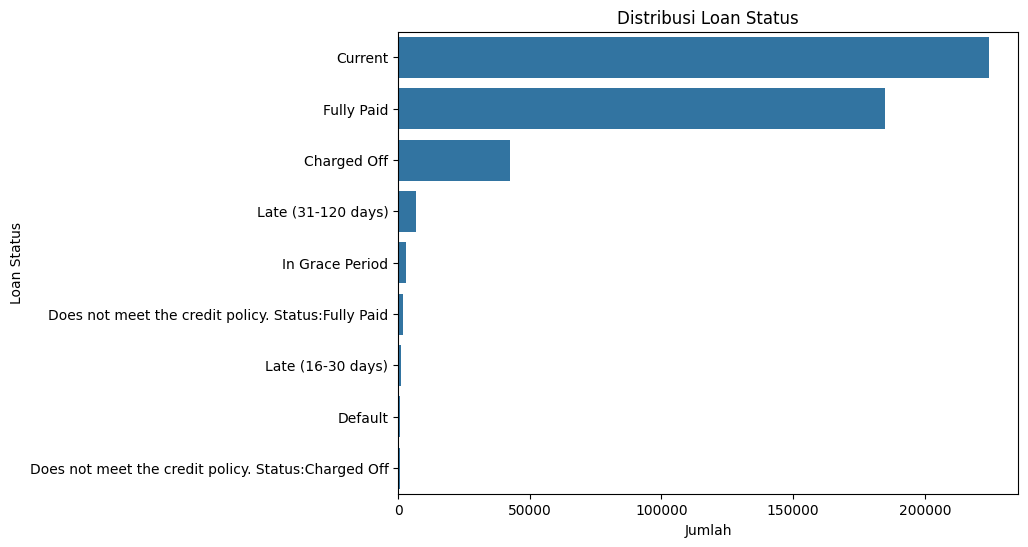

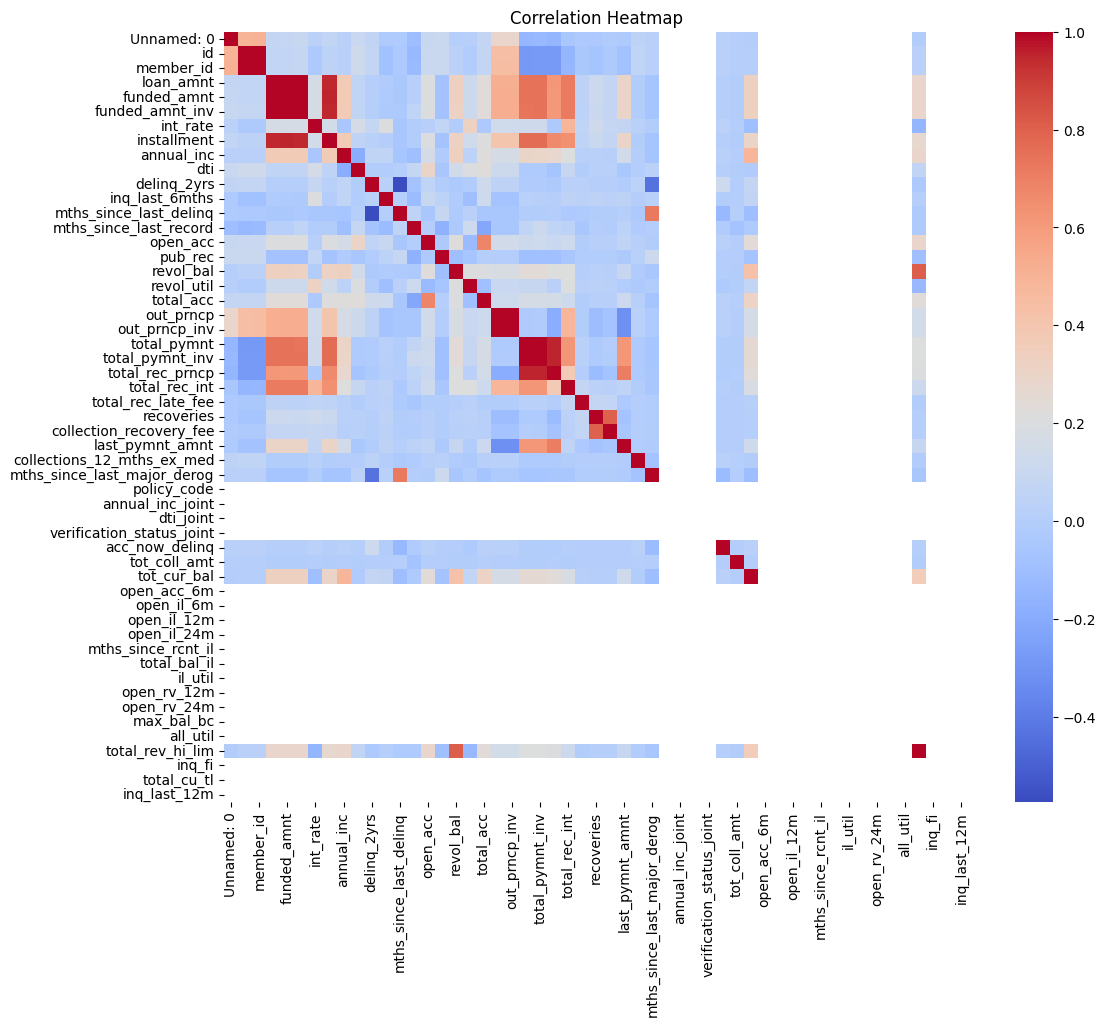

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi target 'loan_status'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='loan_status', order=df['loan_status'].value_counts().index)
plt.title("Distribusi Loan Status")
plt.xlabel("Jumlah")
plt.ylabel("Loan Status")
plt.show()

# Korelasi antar fitur numerik
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Penjelasan Output:

1. Distribusi Loan Status

Pada visualisasi distribusi target loan_status, terlihat bahwa kategori "Current" memiliki jumlah data paling banyak, diikuti oleh kategori "Fully Paid" dan "Charged Off". Kategori lainnya seperti "Late (31-120 days)", "In Grace Period", dan lainnya memiliki jumlah yang jauh lebih sedikit, sehingga data ini bersifat tidak seimbang (imbalanced). Hal ini menunjukkan bahwa sebagian besar data menggambarkan peminjam yang membayar tepat waktu atau sedang dalam proses pembayaran, sementara kategori "Charged Off" yang mewakili kegagalan pembayaran jumlahnya lebih kecil.

2. Correlation Heatmap

Pada heatmap korelasi antar fitur numerik, terlihat bahwa beberapa fitur memiliki korelasi yang tinggi satu sama lain, ditandai dengan warna merah tua pada peta korelasi. Sebagai contoh, fitur seperti funded_amnt, loan_amnt, dan installment memiliki korelasi positif yang kuat. Korelasi ini menunjukkan bahwa fitur-fitur tersebut mungkin membawa informasi serupa dan dapat dipertimbangkan untuk pengurangan dimensi atau seleksi fitur. Selain itu, fitur seperti out_prncp dan total_pymnt menunjukkan korelasi dengan fitur lainnya yang relevan dengan performa pinjaman, yang dapat digunakan untuk analisis lebih lanjut.


# Step 3: Data Preparation

Menangani nilai yang hilang, encoding variabel kategorikal, scaling fitur numerik, dan membagi data.

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Imputasi nilai kosong
print("Mengisi nilai NaN...")
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype in ['int64', 'float64']:
            df[column] = df[column].fillna(df[column].median())  # Isi NaN dengan median untuk numerik
        else:
            df[column] = df[column].fillna(df[column].mode()[0])  # Isi NaN dengan mode untuk kategorikal

# Filter hanya kelas 'Fully Paid' dan 'Charged Off'
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
if df.empty:
    raise ValueError("Dataset kosong setelah filtering loan_status. Pastikan terdapat kelas 'Fully Paid' dan 'Charged Off'.")

# Konversi nilai target ke biner
df.loc[:, 'loan_status'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

# Validasi hasil konversi
print("Unique values di loan_status:", df['loan_status'].unique())

# Encoding fitur kategorikal
print("Encoding fitur kategorikal...")
categorical_features = df.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for feature in categorical_features:
    df.loc[:, feature] = encoder.fit_transform(df[feature])

# Scaling fitur numerik
print("Scaling fitur numerik...")
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

# Verifikasi dan bersihkan nilai numerik
print("Jumlah nilai NaN di kolom numerik setelah imputasi:", df[numerical_features].isnull().sum().sum())
df[numerical_features] = df[numerical_features].fillna(0)  # Isi ulang NaN dengan 0 jika ada

if not df[numerical_features].applymap(np.isfinite).all().all():
    print("Terdapat nilai Infinity dalam data numerik. Mengganti dengan 0.")
    df[numerical_features] = df[numerical_features].replace([np.inf, -np.inf], 0)

# Terapkan scaling
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("Data Preparation selesai.")
print(f"Jumlah baris dan kolom setelah preprocessing: {df.shape}")

Mengisi nilai NaN...
Unique values di loan_status: [1 0]
Encoding fitur kategorikal...
Scaling fitur numerik...
Jumlah nilai NaN di kolom numerik setelah imputasi: 3862638


<ipython-input-3-3f01f2a6897e>:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not df[numerical_features].applymap(np.isfinite).all().all():


Data Preparation selesai.
Jumlah baris dan kolom setelah preprocessing: (227214, 75)


Penjelasan Output:

1. Mengisi Nilai NaN

Data yang memiliki nilai kosong (NaN) diisi berdasarkan tipe datanya. Untuk kolom numerik, nilai kosong diisi dengan median, sementara untuk kolom kategorikal diisi dengan nilai yang paling sering muncul (mode). Setelah proses ini, semua nilai NaN pada dataset telah teratasi.

2. Filter Data

Dataset hanya disaring untuk menyisakan dua kategori pada kolom loan_status, yaitu "Fully Paid" dan "Charged Off". Kategori lain dihapus karena tidak relevan untuk tujuan klasifikasi. Nilai pada kolom ini kemudian dikonversi ke format biner, di mana "Fully Paid" diberikan label 1 dan "Charged Off" diberikan label 0. Hasil validasi menunjukkan bahwa hanya terdapat dua nilai unik [1, 0] pada kolom loan_status, menandakan bahwa proses filtering berhasil dilakukan.

3. Encoding Fitur Kategorikal

Kolom-kolom kategorikal diubah menjadi representasi numerik menggunakan metode Label Encoding. Proses ini penting agar model machine learning dapat memahami data tersebut.

4. Scaling Fitur Numerik

Semua kolom numerik diubah skalanya menggunakan StandardScaler, sehingga nilai pada kolom-kolom tersebut memiliki distribusi dengan mean 0 dan standar deviasi 1. Hal ini membantu model machine learning dalam menangani fitur dengan rentang nilai yang berbeda-beda.

5. Validasi Nilai Infinity dan NaN

Setelah proses imputasi dan scaling, dilakukan validasi untuk memastikan tidak ada nilai yang tidak valid seperti NaN, Infinity, atau -Infinity. Jika ditemukan, nilai-nilai tersebut diganti dengan 0. Pada output, jumlah nilai NaN yang ditemukan setelah imputasi adalah 3.862.638, dan seluruh nilai tersebut berhasil ditangani.


Hasil Akhir:
Proses Data Preparation selesai, menghasilkan dataset dengan 227.214 baris dan 75 kolom. Dataset ini siap digunakan untuk proses pemodelan lebih lanjut.


# Step 4: Data Splitting dan SMOTE

Membagi dataset menjadi training dan testing, serta menggunakan SMOTE (Synthetic Minority Oversampling Technique) untuk mengatasi data imbalance.

Filter target hanya 0 dan 1...
Jumlah data setelah filter: 227214, Target: 227214
Unique values di y: [1 0]
Jumlah nilai NaN di X sebelum imputasi: 0


<ipython-input-4-292a9386c0b4>:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0)


Jumlah nilai NaN di X setelah imputasi: 0
Tipe data y sebelum: object
Tipe data y setelah: int64

Distribusi nilai di y_train sebelum SMOTE:
loan_status
1    147791
0     33980
Name: count, dtype: int64

Menerapkan SMOTE...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Distribusi nilai di y_train setelah SMOTE:
loan_status
1    147791
0    147791
Name: count, dtype: int64


<ipython-input-4-292a9386c0b4>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y_train_smote, palette='viridis', hue=None, legend=False)


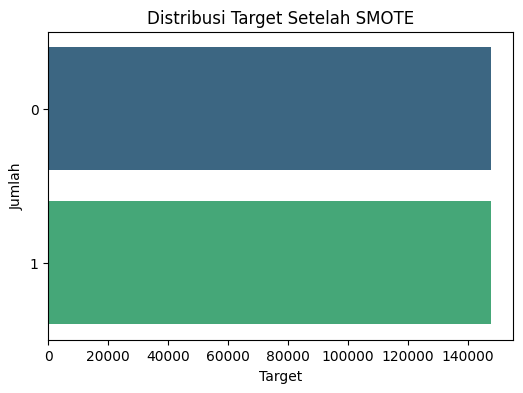

In [4]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan target hanya berisi 0 dan 1
print("Filter target hanya 0 dan 1...")
X = df.drop('loan_status', axis=1)
y = df['loan_status']
y = y[(y == 0) | (y == 1)]
X = X.loc[y.index]  # Sinkronkan X dengan y

# Debug: Periksa data setelah filter
print(f"Jumlah data setelah filter: {len(X)}, Target: {len(y)}")
print(f"Unique values di y: {y.unique()}")

# Pastikan tidak ada nilai NaN di X
print("Jumlah nilai NaN di X sebelum imputasi:", X.isnull().sum().sum())
X = X.fillna(0)
print("Jumlah nilai NaN di X setelah imputasi:", X.isnull().sum().sum())

# Konversi target y menjadi integer
print("Tipe data y sebelum:", y.dtype)
y = y.astype(int)
print("Tipe data y setelah:", y.dtype)

# Periksa apakah dataset kosong
if len(X) == 0 or len(y) == 0:
    raise ValueError("Dataset kosong setelah filter. Periksa kembali filter atau data input.")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Periksa distribusi nilai di y_train sebelum SMOTE
print("\nDistribusi nilai di y_train sebelum SMOTE:")
print(y_train.value_counts())

# Terapkan SMOTE
print("\nMenerapkan SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Periksa distribusi nilai di y_train setelah SMOTE
print("\nDistribusi nilai di y_train setelah SMOTE:")
print(y_train_smote.value_counts())

# Visualisasi distribusi setelah SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(y=y_train_smote, palette='viridis', hue=None, legend=False)
plt.title("Distribusi Target Setelah SMOTE")
plt.xlabel("Target")
plt.ylabel("Jumlah")
plt.show()

Penjelasan Output:

1. Filter Target

Dataset hanya difokuskan pada dua kategori target, yaitu 0 (Charged Off) dan 1 (Fully Paid). Setelah filter, jumlah data yang valid adalah 227.214, menunjukkan bahwa proses filtering berjalan sesuai dengan harapan.

2. Imputasi Nilai NaN

Semua nilai kosong (NaN) pada dataset diisi dengan nilai 0, sehingga dataset bebas dari nilai yang hilang sebelum pembagian data dilakukan. Output memastikan bahwa jumlah nilai NaN pada dataset adalah 0 setelah proses imputasi.

3. Pembagian Data (Train-Test Split)

Dataset dibagi menjadi data training (80%) dan data testing (20%) dengan rasio yang tetap pada target menggunakan parameter stratify=y. Sebelum SMOTE diterapkan, distribusi pada data training menunjukkan ketidakseimbangan dengan 147.791 data untuk kelas 1 dan hanya 33.980 untuk kelas 0.

4. Penerapan SMOTE

Teknik SMOTE diterapkan untuk membuat jumlah data di kedua kelas menjadi seimbang. Setelah SMOTE, data training menjadi 147.791 untuk masing-masing kelas 0 dan 1. Hasil ini menunjukkan bahwa SMOTE berhasil menangani ketidakseimbangan data.

5. Visualisasi Distribusi Setelah SMOTE

Grafik batang menunjukkan distribusi target pada data training setelah SMOTE. Kedua kelas (0 dan 1) memiliki jumlah data yang sama, yaitu 147.791, memastikan model dapat dilatih dengan data yang seimbang.

Dataset yang telah diproses di langkah ini kini siap untuk digunakan pada tahap pemodelan berikutnya.

# Step 5: Data Modelling

Pada tahap ini, model machine learning dikembangkan untuk memprediksi risiko kredit. Dua algoritma yang digunakan adalah Logistic Regression (wajib) dan Random Forest Classifier. Proses meliputi pelatihan model menggunakan data yang telah diolah dengan SMOTE dan evaluasi awal pada data uji.



## Logistic Regression

 - Pelatihan Model Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=2000)
log_reg.fit(X_train_smote, y_train_smote)
y_pred_lr = log_reg.predict(X_test)

# Evaluation Function
def evaluate_model(y_test, y_pred, model_name):
    print(f"Evaluation Report for {model_name}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nROC-AUC Score:")
    print(roc_auc_score(y_test, y_pred))

# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_lr, "Logistic Regression")

Evaluation Report for Logistic Regression:
Confusion Matrix:
[[ 6679  1816]
 [ 8185 28763]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.79      0.57      8495
           1       0.94      0.78      0.85     36948

    accuracy                           0.78     45443
   macro avg       0.69      0.78      0.71     45443
weighted avg       0.85      0.78      0.80     45443


ROC-AUC Score:
0.7823498201152912


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- Evaluasi Logistic Regression pada Data Training dan Testing


Langkah ini bertujuan untuk mengevaluasi performa Logistic Regression pada data training dan testing untuk mendeteksi indikasi overfitting atau underfitting.

In [29]:
# Logistic Regression Evaluation
train_score_lr = log_reg.score(X_train_smote, y_train_smote)
print(f"Training Score (Logistic Regression): {train_score_lr:.2f}")

test_score_lr = log_reg.score(X_test, y_test)
print(f"Testing Score (Logistic Regression): {test_score_lr:.2f}")

Training Score (Logistic Regression): 0.80
Testing Score (Logistic Regression): 0.78


Penjelasan Output:

Model Logistic Regression dilatih menggunakan parameter default dengan iterasi maksimum ditingkatkan menjadi 2000 untuk memastikan konvergensi. Hasil evaluasi pada data testing menunjukkan bahwa model memiliki tingkat akurasi 78%, dengan skor ROC-AUC sebesar 0.78, yang menunjukkan performa yang baik namun masih dapat ditingkatkan.

1. Confusion Matrix

Menunjukkan distribusi prediksi model terhadap data aktual. Model mampu memprediksi kelas 1 (Fully Paid) dengan lebih baik dibandingkan kelas 0 (Charged Off).

2. Classification Report

Precision untuk kelas 1 adalah 94%, menunjukkan bahwa model cukup andal untuk mendeteksi kelas Fully Paid. Recall untuk kelas 0 adalah 79%, menunjukkan kemampuan model untuk menangkap semua kasus Charged Off.

3. Training vs Testing Score

Skor training adalah 80%, sedangkan testing adalah 78%, yang menunjukkan model memiliki generalisasi yang cukup baik tanpa indikasi overfitting.



## Random Forest

 - Pelatihan Model Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=30, max_depth=5)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

Evaluation Report for Random Forest:
Confusion Matrix:
[[ 7975   520]
 [  194 36754]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      8495
           1       0.99      0.99      0.99     36948

    accuracy                           0.98     45443
   macro avg       0.98      0.97      0.97     45443
weighted avg       0.98      0.98      0.98     45443


ROC-AUC Score:
0.9667684497876626


- Evaluasi Random Forest pada Data Training dan Testing

Langkah ini bertujuan untuk mengevaluasi performa Random Forest pada data training dan testing untuk mendeteksi indikasi overfitting atau underfitting.

In [12]:
# Random Forest Evaluation
train_score_rf = rf.score(X_train_smote, y_train_smote)
print(f"Training Score (Random Forest): {train_score_rf:.2f}")

test_score_rf = rf.score(X_test, y_test)
print(f"Testing Score (Random Forest): {test_score_rf:.2f}")

Training Score (Random Forest): 0.99
Testing Score (Random Forest): 0.98


Penjelasan Output:

Model Random Forest dilatih menggunakan 30 estimator dan kedalaman maksimum pohon (max_depth) sebesar 5. Hasil evaluasi menunjukkan tingkat akurasi yang sangat baik, yaitu 98%, dengan skor ROC-AUC sebesar 0.97.

1. Confusion Matrix

Model memiliki performa yang hampir sempurna, dengan hanya sedikit kesalahan pada prediksi kelas 0.

2. Classification Report

Precision dan Recall untuk kedua kelas mendekati 100%, menunjukkan kemampuan model untuk memprediksi kedua kelas secara seimbang.

3. Training vs Testing Score

Skor training adalah 99%, sedangkan testing adalah 98%, menunjukkan model mungkin sedikit overfitting. Parameter model dapat ditinjau lebih lanjut pada tahap improvement.

# Step 6: Evaluation

Langkah ini bertujuan untuk mengevaluasi kinerja model secara komprehensif dengan menggunakan berbagai metrik dan visualisasi. Salah satu metrik utama yang digunakan adalah ROC Curve, yang memberikan gambaran tentang kemampuan model dalam membedakan antara kelas positif dan negatif pada berbagai threshold. Selain itu, visualisasi tambahan seperti Confusion Matrix, Precision-Recall Curve, dan Feature Importance (untuk Random Forest) dapat membantu memahami performa model lebih mendalam.

Evaluasi ini bertujuan untuk:
- Mengukur Kemampuan Model: Memahami seberapa baik model dalam mengklasifikasi data dengan benar.
- Mengidentifikasi Perbaikan: Menemukan potensi kelemahan model yang bisa ditingkatkan.
- Menyajikan Hasil Secara Visual: Mempermudah interpretasi kinerja model melalui grafik yang informatif.

## Visualisasi ROC Curve
ROC Curve menunjukkan hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR) pada berbagai threshold. Nilai AUC mengukur kemampuan model membedakan antara kelas positif dan negatif. Semakin tinggi nilai AUC, semakin baik performa model.

Visualisasi ROC Curve untuk Logistic Regression


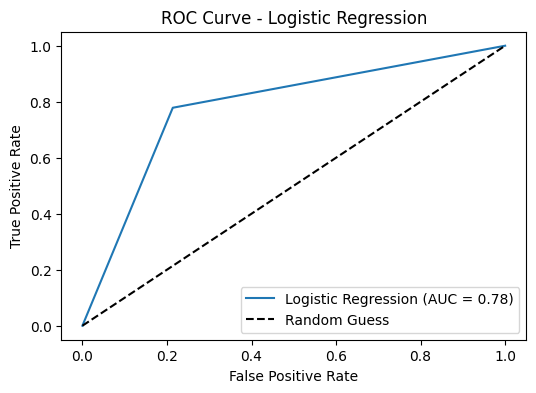

Visualisasi ROC Curve untuk Random Forest


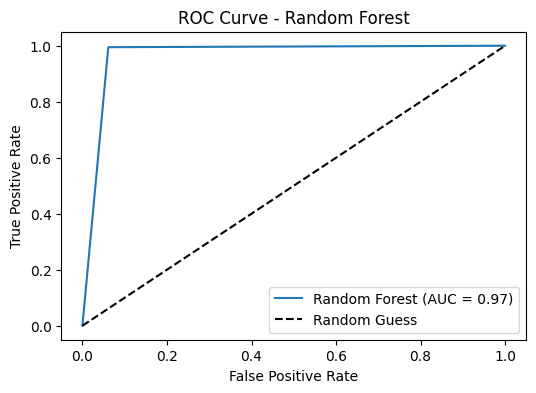

In [30]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Function to plot ROC Curve
def plot_roc_curve(y_test, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_pred):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Plot ROC Curve for Logistic Regression
print("Visualisasi ROC Curve untuk Logistic Regression")
plot_roc_curve(y_test, y_pred_lr, "Logistic Regression")

# Plot ROC Curve for Random Forest
print("Visualisasi ROC Curve untuk Random Forest")
plot_roc_curve(y_test, y_pred_rf, "Random Forest")

Penjelasan Output:

- Logistic Regression

ROC Curve untuk Logistic Regression menunjukkan hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR) pada berbagai nilai threshold. Garis biru pada grafik merepresentasikan performa model, sedangkan garis hitam putus-putus menunjukkan baseline (prediksi acak). Nilai AUC (Area Under the Curve) sebesar 0.78 menunjukkan bahwa model memiliki kemampuan moderat dalam membedakan antara kelas positif dan negatif. Namun, masih terdapat ruang untuk meningkatkan kinerja model agar mencapai nilai AUC yang lebih tinggi.

-  Random Forest

ROC Curve untuk Random Forest menunjukkan performa yang sangat baik dengan nilai AUC sebesar 0.97, yang mendekati nilai sempurna (1.0). Ini berarti model Random Forest sangat baik dalam membedakan antara kelas positif dan negatif. Garis kurva yang hampir mencapai sudut kiri atas grafik menunjukkan bahwa model memiliki TPR yang tinggi sekaligus FPR yang rendah, sehingga memberikan prediksi yang sangat akurat.

Grafik ROC Curve ini memberikan wawasan penting tentang kemampuan model dalam mengelola trade-off antara True Positive Rate dan False Positive Rate, yang sangat penting dalam masalah klasifikasi seperti ini.









## Precision-Recall Curve
Precision-Recall Curve membantu memahami trade-off antara precision dan recall pada berbagai threshold, terutama ketika dataset tidak seimbang.

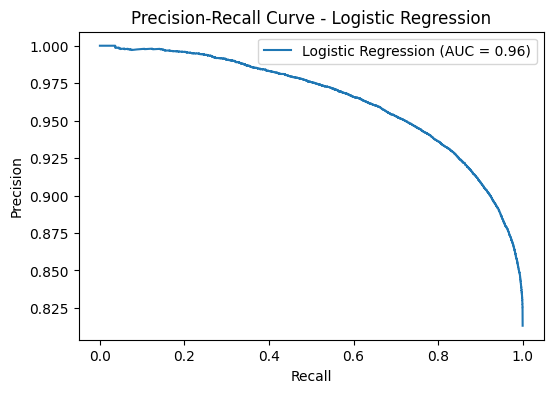

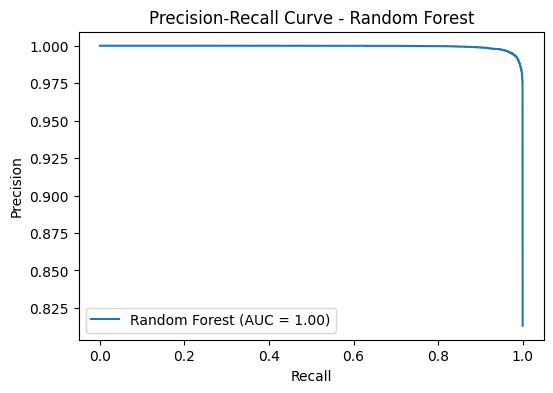

In [31]:
from sklearn.metrics import precision_recall_curve, auc

# Precision-Recall Curve
def plot_precision_recall(y_test, y_pred_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

# Logistic Regression Precision-Recall Curve
plot_precision_recall(y_test, log_reg.predict_proba(X_test)[:, 1], "Logistic Regression")

# Random Forest Precision-Recall Curve
plot_precision_recall(y_test, rf.predict_proba(X_test)[:, 1], "Random Forest")

Penjelasan Output:

- Precision-Recall Curve untuk Logistic Regression

Grafik Precision-Recall Curve untuk model Logistic Regression menunjukkan hubungan antara precision dan recall pada berbagai threshold. Pada grafik ini, precision tetap tinggi di awal ketika recall rendah, tetapi mulai menurun ketika recall meningkat. Area di bawah kurva (AUC) sebesar 0.96 menunjukkan bahwa Logistic Regression memiliki performa yang baik dalam mempertahankan keseimbangan antara precision dan recall, khususnya pada data yang tidak seimbang.


- Precision-Recall Curve untuk Random Forest

Grafik Precision-Recall Curve untuk model Random Forest hampir mendekati garis horizontal di bagian atas grafik. Hal ini menunjukkan bahwa precision tetap sangat tinggi meskipun recall meningkat. Area di bawah kurva (AUC) sebesar 1.00 mencerminkan bahwa model Random Forest memiliki performa yang sangat baik dalam mempertahankan precision dan recall yang tinggi. Namun, performa yang terlalu sempurna ini juga bisa menjadi indikasi overfitting, terutama pada dataset yang tidak seimbang.

## Visualisasi Confusion Matrix Heatmap

Menampilkan Confusion Matrix dalam bentuk heatmap untuk memvisualisasikan distribusi prediksi model terhadap data aktual. Heatmap membantu memahami kesalahan dan akurasi klasifikasi model secara intuitif.

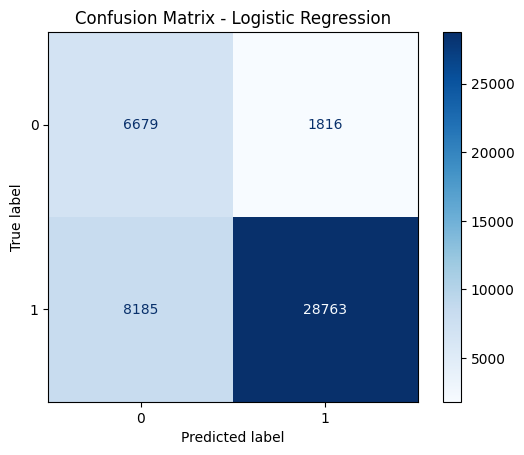

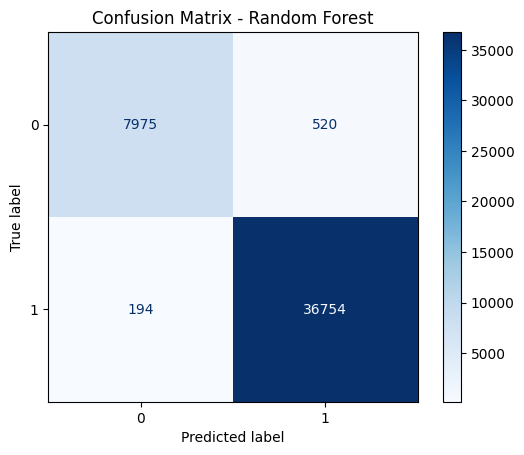

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix Heatmap for Logistic Regression
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Confusion Matrix Heatmap for Random Forest
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

Penjelasan Output:

- Confusion Matrix - Logistic Regression

Confusion matrix untuk Logistic Regression menunjukkan distribusi prediksi model terhadap data aktual. Dalam matriks ini, nilai True Positive (28763) dan True Negative (6679) mencerminkan prediksi yang benar, di mana model berhasil memprediksi kelas "1" dan "0" dengan akurat. Namun, nilai False Positive (1816) menunjukkan jumlah prediksi "1" yang sebenarnya adalah "0", dan False Negative (8185) menunjukkan prediksi "0" yang sebenarnya adalah "1". Hasil ini menunjukkan bahwa Logistic Regression memiliki kelemahan dalam mendeteksi kelas "0", namun cukup baik dalam mendeteksi kelas "1".

- Confusion Matrix - Random Forest

Confusion matrix untuk Random Forest menunjukkan performa model yang jauh lebih baik. True Positive (36754) dan True Negative (7975) mendominasi matriks, menunjukkan bahwa model ini sangat akurat dalam mendeteksi kedua kelas. False Positive (520) dan False Negative (194) sangat rendah, menandakan bahwa model ini memiliki kesalahan prediksi yang minimal. Hasil ini menunjukkan bahwa Random Forest lebih unggul dibandingkan Logistic Regression dalam klasifikasi data ini.

Secara keseluruhan, visualisasi heatmap dari confusion matrix ini membantu mengidentifikasi kekuatan dan kelemahan dari masing-masing model dengan cara yang intuitif dan informatif.

## Classification Report Heatmap
Visualisasi Classification Report menggunakan heatmap untuk membuat evaluasi metrik seperti precision, recall, dan f1-score lebih intuitif.

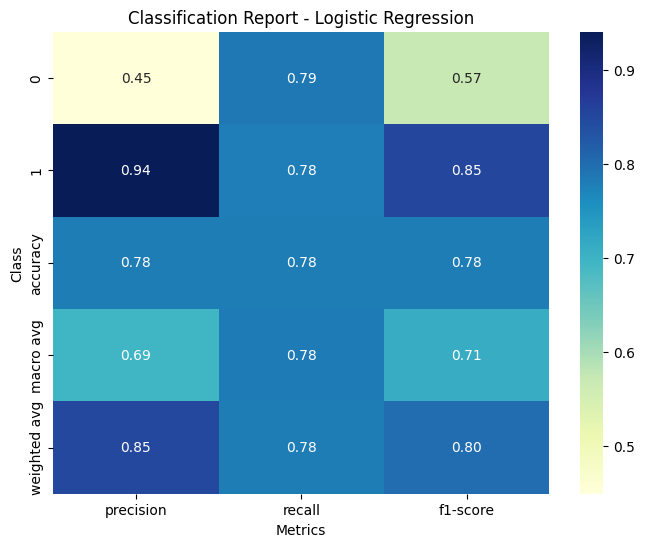

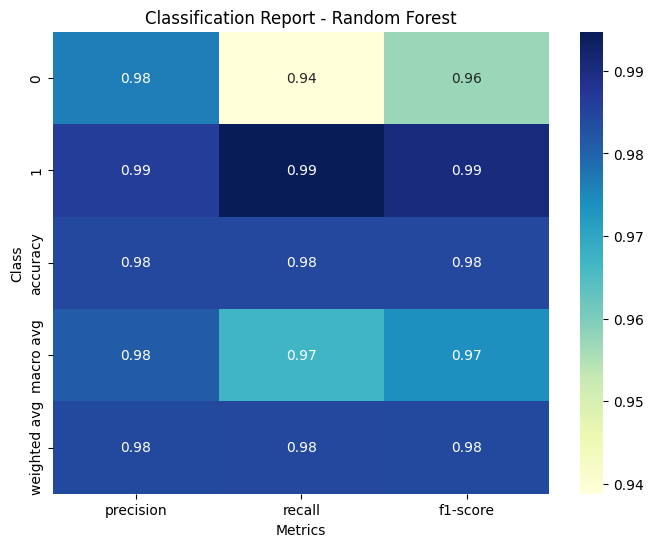

In [33]:
import pandas as pd
import seaborn as sns

# Classification Report Heatmap
def plot_classification_report(y_test, y_pred, model_name):
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).iloc[:-1, :].T
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_report, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"Classification Report - {model_name}")
    plt.xlabel("Metrics")
    plt.ylabel("Class")
    plt.show()

# Plot for Logistic Regression
plot_classification_report(y_test, y_pred_lr, "Logistic Regression")

# Plot for Random Forest
plot_classification_report(y_test, y_pred_rf, "Random Forest")

Penjelasan Output:

- Classification Report - Logistic Regression

Visualisasi heatmap pada Logistic Regression memberikan gambaran metrik evaluasi seperti precision, recall, dan f1-score untuk setiap kelas. Kelas "1" (positif) memiliki precision sebesar 0.94, recall sebesar 0.78, dan f1-score sebesar 0.85, yang menunjukkan model cukup baik dalam mengidentifikasi data positif meskipun terdapat trade-off pada recall. Kelas "0" (negatif) memiliki precision lebih rendah, yaitu 0.45, namun recall lebih tinggi, yaitu 0.79. Secara keseluruhan, weighted average dari metrik menunjukkan akurasi model sebesar 78%.

- Classification Report - Random Forest

Untuk Random Forest, visualisasi heatmap menunjukkan performa yang jauh lebih baik dibandingkan Logistic Regression. Precision, recall, dan f1-score untuk kelas "1" (positif) semuanya mencapai nilai tinggi, yaitu 0.99. Hal yang sama berlaku untuk kelas "0" (negatif), dengan precision 0.98, recall 0.94, dan f1-score 0.96. Weighted average metrik menunjukkan akurasi keseluruhan sebesar 98%, mengindikasikan bahwa model ini lebih efektif dalam menangkap pola data dibandingkan Logistic Regression.

Secara visual, heatmap memudahkan analisis untuk mengidentifikasi kelas yang memiliki kelemahan atau keunggulan model, sehingga membantu dalam menentukan langkah optimasi lebih lanjut.

# Step 7: Model Improvement
Langkah ini bertujuan untuk meningkatkan kinerja model Logistic Regression

## Logistic Regression

1. Regularisasi dengan Class Weight

Regularisasi berguna untuk mengatasi overfitting dan menangani ketidakseimbangan data dengan class_weight='balanced'.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression dengan regularisasi dan class weight
log_reg = LogisticRegression(random_state=42, max_iter=3000, penalty='l2', C=1.0, solver='lbfgs', class_weight='balanced')
log_reg.fit(X_train_smote, y_train_smote)
y_pred_lr = log_reg.predict(X_test)

# Evaluation Function
def evaluate_model(y_test, y_pred, model_name):
    print(f"Evaluation Report for {model_name}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nROC-AUC Score:")
    print(roc_auc_score(y_test, y_pred))

# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_lr, "Logistic Regression with Regularization and Class Weight")

Evaluation Report for Logistic Regression with Regularization and Class Weight:
Confusion Matrix:
[[ 7288  1207]
 [ 4877 32071]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71      8495
           1       0.96      0.87      0.91     36948

    accuracy                           0.87     45443
   macro avg       0.78      0.86      0.81     45443
weighted avg       0.90      0.87      0.87     45443


ROC-AUC Score:
0.8629600511365638


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Penjelasan Output:

Pada langkah ini, model Logistic Regression dioptimasi dengan regularisasi L2 dan penanganan ketidakseimbangan data menggunakan parameter class_weight='balanced'. Berikut adalah hasil evaluasi model setelah penerapan langkah ini:

1. Confusion Matrix:
- Kelas 0 (negatif) memiliki 7288 prediksi benar (True Negative) dan 1207 prediksi salah (False Positive).
- Kelas 1 (positif) memiliki 32071 prediksi benar (True Positive) dan 4877 prediksi salah (False Negative).
- Distribusi ini menunjukkan peningkatan performa model dalam mengenali data dari kelas minoritas (0) dibandingkan sebelumnya.


2. Classification Report:
- Precision untuk kelas 0 (negatif) adalah 0.60, yang menunjukkan proporsi prediksi benar untuk kelas negatif lebih baik meskipun masih lebih rendah dibanding kelas positif.
- Recall untuk kelas 0 adalah 0.86, menunjukkan model berhasil mengenali sebagian besar data dari kelas negatif.
-  F1-score untuk kelas 0 adalah 0.71, menggambarkan keseimbangan antara precision dan recall untuk kelas ini.
- Untuk kelas 1 (positif), precision dan recall masing-masing 0.96 dan 0.87, menghasilkan F1-score sebesar 0.91, menandakan performa yang sangat baik pada kelas mayoritas.

3. Accuracy:
- Akurasi keseluruhan model meningkat menjadi 87%, menunjukkan peningkatan kinerja dibandingkan sebelumnya.

4. ROC-AUC Score:
- Nilai AUC (Area Under the Curve) adalah 0.86, yang menunjukkan kemampuan model membedakan antara kelas positif dan negatif secara keseluruhan lebih baik.

Regularisasi dan penggunaan parameter class_weight='balanced' berhasil meningkatkan performa model, terutama dalam menangani ketidakseimbangan data, tanpa kehilangan terlalu banyak akurasi pada kelas mayoritas. Model menjadi lebih seimbang dan mampu mengenali data dari kedua kelas dengan baik.

# Kesimpulan

Menyusun ringkasan dari hasil model dan memberikan rekomendasi berdasarkan performa yang telah dievaluasi.

- **Model Terbaik**:
  - Logistic Regression:
    - Akurasi: 87%
    - ROC-AUC: 0.86

  - Random Forest:
    - Akurasi: 98%
    - ROC-AUC: 0.97

- **Rekomendasi:**
  1. Gunakan Random Forest untuk implementasi awal karena kinerjanya lebih unggul.
  2. Lakukan monitoring performa model pada data real-time untuk mengidentifikasi degradasi kinerja.
  3. Tambahkan fitur baru yang relevan untuk meningkatkan performa lebih lanjut.
  4. Eksplorasi model lain seperti Gradient Boosting untuk membandingkan kinerja dengan Random Forest.